In [1]:
import tensorflow as tf, albumentations as A
import numpy as np
import os, shutil, random, cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time, copy
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import glob
%matplotlib inline

cudnn.benchmark = True
SEED = 0

def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

{'Train': 47961, 'Valid': 5836, 'Test': 5996}
{'Train': 2998, 'Valid': 730, 'Test': 750}


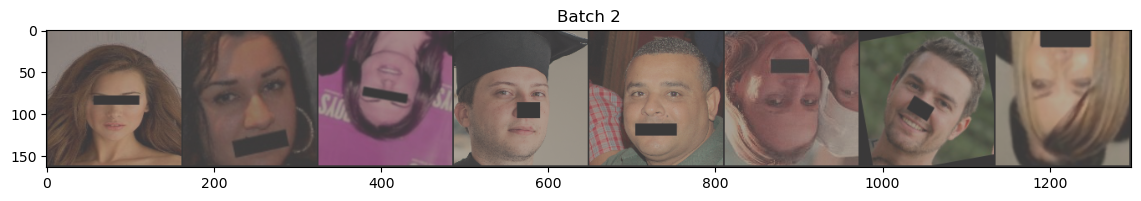

In [2]:
train_transform = transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            # transforms.RandomResizedCrop(size = (160,160), scale=(0.08,1.0), 
            #                              ratio=(0.75, 1.3333333333333333)),
            # transforms.RandomAffine(5, shear=5, scale=(0.7, 0.95)),
            transforms.ToTensor(), #Already makes the image from 0-1 range.
            transforms.Resize((160, 160)),
            # transforms.Normalize(mean = [0.485, 0.456, 0.406], 
            #                      std = [0.229, 0.224, 0.225]),
            ])

testandvalid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((160, 160)),
            ])

class CustomDataSet(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.data = self.create_data()
        self.class_map = {"Real" : 0, "Deepfake": 1}
        self.image_transform = transform
            
    def create_data(self):
        data = []
        file_list = glob.glob(self.root + "*")
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            for img_path in glob.glob(class_path + "\\*.jpg"):
                data.append([img_path, class_name])
        return np.array(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_loc, class_name = self.data[idx]
        image = Image.open(img_loc)
        class_id = self.class_map[class_name]
        if self.image_transform:
            tensor_image = self.image_transform(image)
        return tensor_image, class_id

def create_dataloader(folder, transform, batch_size=64):
    seed_everything()
    dataset = CustomDataSet(folder, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

Train = 'Data\\Train\\'
Valid = 'Data\\Validation\\'
Test = 'Data\\Test\\'
train_dataloader = create_dataloader(Train, train_transform, batch_size=16)
valid_dataloader = create_dataloader(Valid, testandvalid_transform, batch_size=8)
test_dataloader = create_dataloader(Test, testandvalid_transform, batch_size=8)
dataset_sizes = {'Train': len(train_dataloader.dataset),
                 'Valid': len(valid_dataloader.dataset),
                 'Test': len(test_dataloader.dataset)}

dataloader_sizes = {'Train': len(train_dataloader),
                 'Valid': len(valid_dataloader),
                 'Test': len(test_dataloader)}
dataloader_dict = {'Train': train_dataloader, 
                   'Valid': valid_dataloader,
                   'Test': test_dataloader}
print(dataset_sizes)
print(dataloader_sizes)

def imshow(inp, title = None):
  inp = inp.numpy().transpose((1,2,0))
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  inp = std + inp * mean
  inp = np.clip(inp,0,1)
  plt.figure(figsize = (14,5))
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
#show sample batch of images
images, labels = next(iter(dataloader_dict['Valid']))
out = torchvision.utils.make_grid(images)
imshow(out, 'Batch 2')

In [16]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

model = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
print('Model loaded.')


58889256/58889256 [==============================] - 17s 0us/step
Model loaded.


In [23]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [25]:
top_model = Sequential() # Determines the type of top model
# Adds the convolutional model to the classifier
for layer in model.layers:
    top_model.add(layer)
# formats the input for the classifier to the convolutional base output
top_model.add(Flatten(input_shape=model.output_shape[1:]))

# Condenses the input from flatten down to 256 nodes
top_model.add(Dense(256, activation='relu'))

# Discards a portion of the test data, prevents overfitting. Core Variable 
top_model.add(Dropout(0.5)) #0.5
# top_model.add(Dense(256, activation='relu'))

# Condenses the remaining input down into 2 categories
top_model.add(Dense(2, activation='softmax', name='predictions'))
top_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 40, 40, 256)      

In [68]:
model = models.vgg16(pretrained=True)
model2 = model.features

In [ ]:
        model = models.vgg16(pretrained=True)
        model2 = model.features

In [78]:
from collections import OrderedDict


# Number of classes in the dataset
num_classes = 2
feature_extract = True
N_REPLICAS =2
LR_MAX = 5e-6 * N_REPLICAS
WD_RATIO = 1e-5
EPOCHS = 50



def get_model(modelname=None, feature_extract = True):
    print(modelname)
    if modelname == 'VGG19':
        print("models.VGG19")
        model = models.vgg16(pretrained=True)
        for param in model.parameters():
            if feature_extract:
                param.requires_grad = False
        # Classifier = nn.Sequential(OrderedDict([
        #                         ('fc1', nn.Linear(25088, 4096)),
        #                         ('relu', nn.ReLU()),
        #                         ('dropout', nn.Dropout(p=0.5)),
        #                         ('fc2', nn.Linear(4096, num_classes)),
        #                         ]))
        # model.classifier = Classifier
        Classifier = nn.Linear(in_features=4096, out_features=num_classes, bias=True)
        model.classifier[6] = Classifier
    elif modelname == 'VGG16':
        model = models.vgg16(pretrained=True)
        for param in model.parameters():
            if feature_extract:
                param.requires_grad = False    
        model2 = model.features
        classifier = nn.Sequential(
                        nn.Linear(12800, 2048), nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(2048, 1024), nn.ReLU(),
                        nn.Dropout(p=0.3),
                        nn.Linear(1024, 2),
                        )
        top_m = nn.Sequential()
        top_m.add_module('features', model2)
        top_m.add_module('flatten', nn.Flatten())
        top_m.add_module('classifier', classifier)
        model = top_m
    elif modelname == 'resnet50':
        print("models.resnet50")
        model = models.resnet50(pretrained=True)
        for param in model.parameters():
            if feature_extract:
                param.requires_grad = False
        model.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
    elif modelname == 'resnet101':
        print("models.resnet101")
        model = models.resnet101(pretrained=True)
        for param in model.parameters():
            if feature_extract:
                param.requires_grad = False
        model.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
    elif modelname == 'resnet152':
        print("models.resnet152")
        model = models.resnet152(pretrained=True)
        for param in model.parameters():
            if feature_extract:
                param.requires_grad = False
        model.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
    else:
        print('Effnet_b7')
        model = models.efficientnet_b7(pretrained=True)
        for param in model.parameters():
            if feature_extract:
                param.requires_grad = False
        # Classifier = nn.Sequential(OrderedDict([
        #                     # ('dropout', nn.Dropout(p=0.5, inplace=True)),
        #                     ('fc1', nn.Linear(2560, 1024)),
        #                     ('relu', nn.ReLU()),
        #                     # ('dropout', nn.Dropout(p=0.5, inplace=True)),
        #                     ('fc2', nn.Linear(1024, num_classes)),
        #                     ]))
        Classifier = nn.Linear(in_features=4096, out_features=num_classes, bias=True)
        model.classifier[1] = Classifier
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
    # optimizer_conv = optim.AdamW(params_to_update, lr = LR_MAX, weight_decay=LR_MAX*WD_RATIO, eps=1e-6)
    optimizer_conv = optim.SGD([
                {'params':  model.features.parameters()},
                {'params': params_to_update, 'lr': 1e-3}
            ], lr=1e-2, momentum=0.9)
    criterion_conv = nn.CrossEntropyLoss()
    scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer_conv, gamma=0.9)
    scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer_conv, milestones=[10,80], gamma=0.1)
    # exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

    return model.to(device), criterion_conv, optimizer_conv, scheduler1, scheduler2

model, loss_fn, optimizer, scheduler1, scheduler2 = get_model('VGG16')


VGG16


c:\Users\abdel\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\abdel\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [79]:
import gc
def report_gpu():
   gc.collect()
   torch.cuda.empty_cache()
report_gpu()

In [80]:
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score


def train_model(model, dataloaders, criterion, optimizer, scheduler1, scheduler2, num_epochs=EPOCHS):
    seed_everything()
    print(model._get_name())
    since = time.time()
    valid_acc_history, valid_loss_history = [], []
    train_acc_history, train_loss_history = [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        targets, ops = [], []
        start_epoch = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('--' * 50)
        for phase in ['Train', 'Valid']:
            if phase == 'Train':
                model.train()
            else:
                model.eval() 
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
                targets.append(labels.detach().cpu().numpy())
                ops.append(preds.detach().cpu().numpy())
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler1.step()
                scheduler2.step()
            ops_array = np.concatenate(ops)
            targets_array = np.concatenate(targets)
            f1 = f1_score(ops_array, targets_array)
            ps = precision_score(ops_array, targets_array)
            rc = recall_score(ops_array, targets_array)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f} F1-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}'.format(phase, epoch_loss, epoch_acc, f1, ps, rc))
            if phase == 'Valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'Valid':
                valid_acc_history.append(epoch_acc)
                valid_loss_history.append(epoch_loss)

            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                
        print('Epoch completed in {:.0f}m {:.0f}s'.format((time.time()-start_epoch) // 60, (time.time()-start_epoch) % 60))

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Valid Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, (train_acc_history, valid_acc_history), (train_loss_history, valid_loss_history)

model_ft, acc_hist, loss_hist = train_model(model, dataloader_dict, loss_fn, optimizer, scheduler1, scheduler2)

Sequential
Epoch 1/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [06:39<00:00,  7.51it/s]


Train Loss: 0.5751 Acc: 0.6905 F1-score: 0.6939, Precision: 0.7022, Recall: 0.6858


100%|██████████| 730/730 [00:47<00:00, 15.39it/s]


Valid Loss: 0.5419 Acc: 0.7138 F1-score: 0.6951, Precision: 0.7026, Recall: 0.6878
Epoch completed in 7m 27s

Epoch 2/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:52<00:00, 12.88it/s]


Train Loss: 0.5133 Acc: 0.7431 F1-score: 0.7457, Precision: 0.7538, Recall: 0.7378


100%|██████████| 730/730 [00:26<00:00, 27.46it/s]


Valid Loss: 0.5088 Acc: 0.7442 F1-score: 0.7441, Precision: 0.7495, Recall: 0.7388
Epoch completed in 4m 20s

Epoch 3/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:53<00:00, 12.84it/s]


Train Loss: 0.4768 Acc: 0.7683 F1-score: 0.7700, Precision: 0.7761, Recall: 0.7640


100%|██████████| 730/730 [00:26<00:00, 27.51it/s]


Valid Loss: 0.5123 Acc: 0.7399 F1-score: 0.7633, Precision: 0.7600, Recall: 0.7667
Epoch completed in 4m 20s

Epoch 4/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:52<00:00, 12.88it/s]


Train Loss: 0.4499 Acc: 0.7842 F1-score: 0.7860, Precision: 0.7932, Recall: 0.7790


100%|██████████| 730/730 [00:26<00:00, 27.47it/s]


Valid Loss: 0.4701 Acc: 0.7738 F1-score: 0.7828, Precision: 0.7844, Recall: 0.7811
Epoch completed in 4m 19s

Epoch 5/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:53<00:00, 12.86it/s]


Train Loss: 0.4278 Acc: 0.7990 F1-score: 0.8002, Precision: 0.8059, Recall: 0.7947


100%|██████████| 730/730 [00:26<00:00, 27.58it/s]


Valid Loss: 0.4784 Acc: 0.7668 F1-score: 0.7988, Precision: 0.8150, Recall: 0.7833
Epoch completed in 4m 20s

Epoch 6/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:52<00:00, 12.89it/s]


Train Loss: 0.4082 Acc: 0.8101 F1-score: 0.8115, Precision: 0.8182, Recall: 0.8048


100%|██████████| 730/730 [00:26<00:00, 27.71it/s]


Valid Loss: 0.4424 Acc: 0.7874 F1-score: 0.8073, Precision: 0.8093, Recall: 0.8054
Epoch completed in 4m 19s

Epoch 7/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:53<00:00, 12.85it/s]


Train Loss: 0.3926 Acc: 0.8200 F1-score: 0.8213, Precision: 0.8279, Recall: 0.8147


100%|██████████| 730/730 [00:26<00:00, 27.73it/s]


Valid Loss: 0.4283 Acc: 0.7964 F1-score: 0.8182, Precision: 0.8249, Recall: 0.8116
Epoch completed in 4m 20s

Epoch 8/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:53<00:00, 12.86it/s]


Train Loss: 0.3734 Acc: 0.8292 F1-score: 0.8303, Precision: 0.8364, Recall: 0.8242


100%|██████████| 730/730 [00:26<00:00, 27.63it/s]


Valid Loss: 0.4248 Acc: 0.8050 F1-score: 0.8267, Precision: 0.8305, Recall: 0.8229
Epoch completed in 4m 20s

Epoch 9/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:54<00:00, 12.79it/s]


Train Loss: 0.3649 Acc: 0.8337 F1-score: 0.8346, Precision: 0.8398, Recall: 0.8294


100%|██████████| 730/730 [00:26<00:00, 27.65it/s]


Valid Loss: 0.4115 Acc: 0.8074 F1-score: 0.8305, Precision: 0.8322, Recall: 0.8288
Epoch completed in 4m 21s

Epoch 10/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:54<00:00, 12.80it/s]


Train Loss: 0.3512 Acc: 0.8423 F1-score: 0.8430, Precision: 0.8476, Recall: 0.8385


100%|██████████| 730/730 [00:26<00:00, 27.56it/s]


Valid Loss: 0.3911 Acc: 0.8237 F1-score: 0.8404, Precision: 0.8445, Recall: 0.8364
Epoch completed in 4m 21s

Epoch 11/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:53<00:00, 12.86it/s]


Train Loss: 0.3226 Acc: 0.8585 F1-score: 0.8592, Precision: 0.8645, Recall: 0.8540


100%|██████████| 730/730 [00:27<00:00, 26.35it/s]


Valid Loss: 0.3879 Acc: 0.8244 F1-score: 0.8552, Precision: 0.8608, Recall: 0.8496
Epoch completed in 4m 21s

Epoch 12/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:09<00:00, 12.02it/s]


Train Loss: 0.3165 Acc: 0.8618 F1-score: 0.8624, Precision: 0.8665, Recall: 0.8583


100%|██████████| 730/730 [00:27<00:00, 26.66it/s]


Valid Loss: 0.3875 Acc: 0.8264 F1-score: 0.8580, Precision: 0.8617, Recall: 0.8545
Epoch completed in 4m 37s

Epoch 13/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:01<00:00, 12.41it/s]


Train Loss: 0.3160 Acc: 0.8610 F1-score: 0.8617, Precision: 0.8670, Recall: 0.8565


100%|██████████| 730/730 [00:27<00:00, 26.52it/s]


Valid Loss: 0.3856 Acc: 0.8266 F1-score: 0.8575, Precision: 0.8623, Recall: 0.8528
Epoch completed in 4m 29s

Epoch 14/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:00<00:00, 12.46it/s]


Train Loss: 0.3106 Acc: 0.8647 F1-score: 0.8650, Precision: 0.8677, Recall: 0.8623


100%|██████████| 730/730 [00:27<00:00, 26.16it/s]


Valid Loss: 0.3885 Acc: 0.8268 F1-score: 0.8607, Precision: 0.8645, Recall: 0.8569
Epoch completed in 4m 29s

Epoch 15/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:56<00:00, 12.70it/s]


Train Loss: 0.3089 Acc: 0.8667 F1-score: 0.8675, Precision: 0.8732, Recall: 0.8619


100%|██████████| 730/730 [00:27<00:00, 26.57it/s]


Valid Loss: 0.3858 Acc: 0.8280 F1-score: 0.8629, Precision: 0.8688, Recall: 0.8571
Epoch completed in 4m 24s

Epoch 16/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [06:10<00:00,  8.10it/s]


Train Loss: 0.3073 Acc: 0.8687 F1-score: 0.8694, Precision: 0.8748, Recall: 0.8641


100%|██████████| 730/730 [00:50<00:00, 14.48it/s]


Valid Loss: 0.3856 Acc: 0.8268 F1-score: 0.8647, Precision: 0.8712, Recall: 0.8582
Epoch completed in 7m 1s

Epoch 17/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:58<00:00, 10.04it/s]


Train Loss: 0.3042 Acc: 0.8695 F1-score: 0.8701, Precision: 0.8752, Recall: 0.8651


100%|██████████| 730/730 [00:26<00:00, 27.08it/s]


Valid Loss: 0.3858 Acc: 0.8276 F1-score: 0.8653, Precision: 0.8709, Recall: 0.8598
Epoch completed in 5m 26s

Epoch 18/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:03<00:00, 12.33it/s]


Train Loss: 0.3031 Acc: 0.8697 F1-score: 0.8704, Precision: 0.8758, Recall: 0.8651


100%|██████████| 730/730 [00:27<00:00, 26.60it/s]


Valid Loss: 0.3838 Acc: 0.8276 F1-score: 0.8655, Precision: 0.8709, Recall: 0.8601
Epoch completed in 4m 31s

Epoch 19/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:58<00:00, 12.59it/s]


Train Loss: 0.3013 Acc: 0.8683 F1-score: 0.8689, Precision: 0.8735, Recall: 0.8643


100%|██████████| 730/730 [00:26<00:00, 27.15it/s]


Valid Loss: 0.3816 Acc: 0.8297 F1-score: 0.8642, Precision: 0.8681, Recall: 0.8604
Epoch completed in 4m 25s

Epoch 20/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:04<00:00, 12.29it/s]


Train Loss: 0.3002 Acc: 0.8714 F1-score: 0.8718, Precision: 0.8753, Recall: 0.8683


100%|██████████| 730/730 [00:28<00:00, 25.85it/s]


Valid Loss: 0.3838 Acc: 0.8307 F1-score: 0.8672, Precision: 0.8720, Recall: 0.8625
Epoch completed in 4m 32s

Epoch 21/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:06<00:00, 12.17it/s]


Train Loss: 0.3010 Acc: 0.8697 F1-score: 0.8704, Precision: 0.8755, Recall: 0.8653


100%|██████████| 730/730 [00:27<00:00, 26.55it/s]


Valid Loss: 0.3808 Acc: 0.8309 F1-score: 0.8658, Precision: 0.8711, Recall: 0.8606
Epoch completed in 4m 34s

Epoch 22/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:01<00:00, 12.40it/s]


Train Loss: 0.3019 Acc: 0.8713 F1-score: 0.8718, Precision: 0.8756, Recall: 0.8680


100%|██████████| 730/730 [00:27<00:00, 26.47it/s]


Valid Loss: 0.3809 Acc: 0.8293 F1-score: 0.8669, Precision: 0.8712, Recall: 0.8627
Epoch completed in 4m 30s

Epoch 23/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:58<00:00, 12.55it/s]


Train Loss: 0.2935 Acc: 0.8743 F1-score: 0.8747, Precision: 0.8783, Recall: 0.8711


100%|██████████| 730/730 [00:26<00:00, 27.41it/s]


Valid Loss: 0.3807 Acc: 0.8324 F1-score: 0.8698, Precision: 0.8736, Recall: 0.8661
Epoch completed in 4m 26s

Epoch 24/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:01<00:00, 12.40it/s]


Train Loss: 0.2944 Acc: 0.8722 F1-score: 0.8728, Precision: 0.8776, Recall: 0.8681


100%|██████████| 730/730 [00:26<00:00, 27.21it/s]


Valid Loss: 0.3809 Acc: 0.8302 F1-score: 0.8680, Precision: 0.8735, Recall: 0.8626
Epoch completed in 4m 29s

Epoch 25/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:57<00:00, 12.63it/s]


Train Loss: 0.2998 Acc: 0.8706 F1-score: 0.8710, Precision: 0.8747, Recall: 0.8674


100%|██████████| 730/730 [00:27<00:00, 26.97it/s]


Valid Loss: 0.3801 Acc: 0.8290 F1-score: 0.8662, Precision: 0.8706, Recall: 0.8619
Epoch completed in 4m 25s

Epoch 26/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:59<00:00, 12.54it/s]


Train Loss: 0.2974 Acc: 0.8713 F1-score: 0.8717, Precision: 0.8751, Recall: 0.8684


100%|██████████| 730/730 [00:29<00:00, 25.00it/s]


Valid Loss: 0.3798 Acc: 0.8316 F1-score: 0.8670, Precision: 0.8705, Recall: 0.8636
Epoch completed in 4m 28s

Epoch 27/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:00<00:00, 12.46it/s]


Train Loss: 0.2943 Acc: 0.8720 F1-score: 0.8722, Precision: 0.8742, Recall: 0.8703


100%|██████████| 730/730 [00:27<00:00, 26.99it/s]


Valid Loss: 0.3796 Acc: 0.8326 F1-score: 0.8676, Precision: 0.8696, Recall: 0.8655
Epoch completed in 4m 28s

Epoch 28/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:57<00:00, 12.61it/s]


Train Loss: 0.2946 Acc: 0.8735 F1-score: 0.8740, Precision: 0.8781, Recall: 0.8698


100%|██████████| 730/730 [00:27<00:00, 26.92it/s]


Valid Loss: 0.3799 Acc: 0.8317 F1-score: 0.8691, Precision: 0.8733, Recall: 0.8649
Epoch completed in 4m 25s

Epoch 29/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:55<00:00, 12.73it/s]


Train Loss: 0.2941 Acc: 0.8732 F1-score: 0.8735, Precision: 0.8765, Recall: 0.8705


100%|██████████| 730/730 [00:26<00:00, 27.24it/s]


Valid Loss: 0.3805 Acc: 0.8321 F1-score: 0.8688, Precision: 0.8725, Recall: 0.8651
Epoch completed in 4m 23s

Epoch 30/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:56<00:00, 12.68it/s]


Train Loss: 0.2950 Acc: 0.8732 F1-score: 0.8737, Precision: 0.8778, Recall: 0.8696


100%|██████████| 730/730 [00:26<00:00, 27.22it/s]


Valid Loss: 0.3802 Acc: 0.8316 F1-score: 0.8688, Precision: 0.8732, Recall: 0.8645
Epoch completed in 4m 23s

Epoch 31/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:56<00:00, 12.68it/s]


Train Loss: 0.2925 Acc: 0.8750 F1-score: 0.8753, Precision: 0.8782, Recall: 0.8724


100%|██████████| 730/730 [00:27<00:00, 26.83it/s]


Valid Loss: 0.3800 Acc: 0.8312 F1-score: 0.8702, Precision: 0.8736, Recall: 0.8669
Epoch completed in 4m 24s

Epoch 32/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:03<00:00, 12.29it/s]


Train Loss: 0.2954 Acc: 0.8736 F1-score: 0.8740, Precision: 0.8776, Recall: 0.8705


100%|██████████| 730/730 [00:28<00:00, 25.72it/s]


Valid Loss: 0.3795 Acc: 0.8319 F1-score: 0.8692, Precision: 0.8731, Recall: 0.8653
Epoch completed in 4m 32s

Epoch 33/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:05<00:00, 12.23it/s]


Train Loss: 0.2926 Acc: 0.8753 F1-score: 0.8758, Precision: 0.8804, Recall: 0.8713


100%|██████████| 730/730 [00:27<00:00, 26.20it/s]


Valid Loss: 0.3791 Acc: 0.8319 F1-score: 0.8708, Precision: 0.8755, Recall: 0.8661
Epoch completed in 4m 33s

Epoch 34/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:05<00:00, 12.20it/s]


Train Loss: 0.2907 Acc: 0.8754 F1-score: 0.8758, Precision: 0.8795, Recall: 0.8721


100%|██████████| 730/730 [00:27<00:00, 26.77it/s]


Valid Loss: 0.3793 Acc: 0.8317 F1-score: 0.8708, Precision: 0.8748, Recall: 0.8667
Epoch completed in 4m 33s

Epoch 35/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:03<00:00, 12.33it/s]


Train Loss: 0.2928 Acc: 0.8757 F1-score: 0.8764, Precision: 0.8817, Recall: 0.8711


100%|██████████| 730/730 [00:28<00:00, 25.93it/s]


Valid Loss: 0.3788 Acc: 0.8326 F1-score: 0.8713, Precision: 0.8766, Recall: 0.8661
Epoch completed in 4m 31s

Epoch 36/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:06<00:00, 12.15it/s]


Train Loss: 0.2930 Acc: 0.8746 F1-score: 0.8750, Precision: 0.8781, Recall: 0.8718


100%|██████████| 730/730 [00:27<00:00, 26.12it/s]


Valid Loss: 0.3793 Acc: 0.8324 F1-score: 0.8701, Precision: 0.8737, Recall: 0.8665
Epoch completed in 4m 35s

Epoch 37/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:01<00:00, 12.42it/s]


Train Loss: 0.2907 Acc: 0.8753 F1-score: 0.8758, Precision: 0.8795, Recall: 0.8721


100%|██████████| 730/730 [00:27<00:00, 26.86it/s]


Valid Loss: 0.3793 Acc: 0.8314 F1-score: 0.8707, Precision: 0.8747, Recall: 0.8667
Epoch completed in 4m 29s

Epoch 38/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:02<00:00, 12.36it/s]


Train Loss: 0.2913 Acc: 0.8748 F1-score: 0.8753, Precision: 0.8796, Recall: 0.8710


100%|██████████| 730/730 [00:27<00:00, 26.89it/s]


Valid Loss: 0.3790 Acc: 0.8321 F1-score: 0.8703, Precision: 0.8745, Recall: 0.8661
Epoch completed in 4m 30s

Epoch 39/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:57<00:00, 12.60it/s]


Train Loss: 0.2923 Acc: 0.8759 F1-score: 0.8762, Precision: 0.8791, Recall: 0.8734


100%|██████████| 730/730 [00:26<00:00, 27.12it/s]


Valid Loss: 0.3791 Acc: 0.8314 F1-score: 0.8711, Precision: 0.8744, Recall: 0.8678
Epoch completed in 4m 25s

Epoch 40/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:58<00:00, 12.55it/s]


Train Loss: 0.2918 Acc: 0.8750 F1-score: 0.8756, Precision: 0.8808, Recall: 0.8705


100%|██████████| 730/730 [00:27<00:00, 26.68it/s]


Valid Loss: 0.3789 Acc: 0.8324 F1-score: 0.8706, Precision: 0.8757, Recall: 0.8656
Epoch completed in 4m 26s

Epoch 41/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:58<00:00, 12.57it/s]


Train Loss: 0.2928 Acc: 0.8732 F1-score: 0.8736, Precision: 0.8771, Recall: 0.8702


100%|██████████| 730/730 [00:27<00:00, 26.97it/s]


Valid Loss: 0.3790 Acc: 0.8329 F1-score: 0.8689, Precision: 0.8723, Recall: 0.8655
Epoch completed in 4m 26s

Epoch 42/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:59<00:00, 12.52it/s]


Train Loss: 0.2888 Acc: 0.8770 F1-score: 0.8774, Precision: 0.8810, Recall: 0.8738


100%|██████████| 730/730 [00:27<00:00, 26.80it/s]


Valid Loss: 0.3790 Acc: 0.8317 F1-score: 0.8721, Precision: 0.8758, Recall: 0.8685
Epoch completed in 4m 27s

Epoch 43/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:58<00:00, 12.58it/s]


Train Loss: 0.2930 Acc: 0.8744 F1-score: 0.8748, Precision: 0.8786, Recall: 0.8712


100%|██████████| 730/730 [00:27<00:00, 26.12it/s]


Valid Loss: 0.3791 Acc: 0.8321 F1-score: 0.8699, Precision: 0.8737, Recall: 0.8661
Epoch completed in 4m 26s

Epoch 44/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:58<00:00, 12.54it/s]


Train Loss: 0.2921 Acc: 0.8766 F1-score: 0.8769, Precision: 0.8792, Recall: 0.8745


100%|██████████| 730/730 [00:26<00:00, 27.18it/s]


Valid Loss: 0.3789 Acc: 0.8319 F1-score: 0.8717, Precision: 0.8743, Recall: 0.8691
Epoch completed in 4m 26s

Epoch 45/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:57<00:00, 12.63it/s]


Train Loss: 0.2919 Acc: 0.8751 F1-score: 0.8756, Precision: 0.8801, Recall: 0.8712


100%|██████████| 730/730 [00:26<00:00, 27.09it/s]


Valid Loss: 0.3787 Acc: 0.8324 F1-score: 0.8706, Precision: 0.8750, Recall: 0.8662
Epoch completed in 4m 24s

Epoch 46/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:58<00:00, 12.57it/s]


Train Loss: 0.2936 Acc: 0.8719 F1-score: 0.8723, Precision: 0.8757, Recall: 0.8690


100%|██████████| 730/730 [00:27<00:00, 26.86it/s]


Valid Loss: 0.3787 Acc: 0.8322 F1-score: 0.8677, Precision: 0.8712, Recall: 0.8641
Epoch completed in 4m 26s

Epoch 47/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:58<00:00, 12.57it/s]


Train Loss: 0.2925 Acc: 0.8749 F1-score: 0.8752, Precision: 0.8779, Recall: 0.8725


100%|██████████| 730/730 [00:26<00:00, 27.14it/s]


Valid Loss: 0.3786 Acc: 0.8317 F1-score: 0.8702, Precision: 0.8732, Recall: 0.8672
Epoch completed in 4m 26s

Epoch 48/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:59<00:00, 12.54it/s]


Train Loss: 0.2916 Acc: 0.8742 F1-score: 0.8748, Precision: 0.8795, Recall: 0.8701


100%|██████████| 730/730 [00:27<00:00, 26.82it/s]


Valid Loss: 0.3785 Acc: 0.8321 F1-score: 0.8699, Precision: 0.8746, Recall: 0.8652
Epoch completed in 4m 26s

Epoch 49/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:58<00:00, 12.56it/s]


Train Loss: 0.2911 Acc: 0.8756 F1-score: 0.8760, Precision: 0.8797, Recall: 0.8724


100%|██████████| 730/730 [00:26<00:00, 27.07it/s]


Valid Loss: 0.3785 Acc: 0.8319 F1-score: 0.8709, Precision: 0.8748, Recall: 0.8672
Epoch completed in 4m 26s

Epoch 50/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [03:57<00:00, 12.60it/s]


Train Loss: 0.2914 Acc: 0.8750 F1-score: 0.8754, Precision: 0.8788, Recall: 0.8720


100%|██████████| 730/730 [00:27<00:00, 26.99it/s]

Valid Loss: 0.3785 Acc: 0.8319 F1-score: 0.8704, Precision: 0.8740, Recall: 0.8668
Epoch completed in 4m 25s

Training complete in 228m 26s
Best Valid Acc: 0.832934


In [3]:
import tensorflow as tf
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (160, 160)
Train = 'Data\\Train\\'
Valid = 'Data\\Validation\\'
Test = 'Data\\Test\\'

train_dataset = tf.keras.utils.image_dataset_from_directory(Train,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

valid_dataset = tf.keras.utils.image_dataset_from_directory(Valid,
                                                            shuffle=True,
                                                            batch_size=8,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(Test,
                                                            shuffle=True,
                                                            batch_size=8,
                                                            image_size=IMG_SIZE)

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 47961 files belonging to 2 classes.
Found 5836 files belonging to 2 classes.
Found 5996 files belonging to 2 classes.


In [4]:
def normalize(image):
#     # Repeat channels to create 3 channel images required by pretrained ConvNextV2 models
#     image = tf.repeat(image, repeats=3, axis=3)
    # Cast to float 32
    image = tf.cast(image, tf.float32)
    # Normalize with respect to ImageNet mean/std
    image = tf.keras.applications.imagenet_utils.preprocess_input(image, mode='torch')

    return image

In [95]:
import gc
def report_gpu():
   gc.collect()
   torch.cuda.empty_cache()
report_gpu()

In [5]:
def get_model():
#     # Verify Mixed Policy Settings
#     print(f'Compute dtype: {tf.keras.mixed_precision.global_policy().compute_dtype}')
#     print(f'Variable dtype: {tf.keras.mixed_precision.global_policy().variable_dtype}')
    INPUT_SHAPE = (160, 160, 3)
    
    # Set seed for deterministic weights initialization
    seed_everything()
        
    # Inputs, note the names are equal to the dictionary keys in the dataset
    image = tf.keras.layers.Input(INPUT_SHAPE, name='image', dtype=tf.uint8)
    # Normalize Input
    image_norm = normalize(image)

    # CNN Prediction in range [0,1]
    x = tf.keras.applications.VGG16(
        input_shape=(160, 160, 3),
        include_top=False,)(image_norm)
        
    # Average Pooling BxHxWxC -> BxC
    x = tf.keras.layers.Flatten()(x)
    # Dropout to prevent Overfitting
    x = tf.keras.layers.Dropout(0.50)(x)
    # Output value between [0, 1] using Sigmoid function
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # We will use the famous AdamW optimizer for fast learning with weight decay
    optimizer = tf.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

        # Loss
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        
        # Metrics
    metrics = [
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.BinaryAccuracy(),
        ]

    model = tf.keras.models.Model(inputs=image, outputs=outputs)
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [6]:
model = get_model()
history = model.fit(
            train_dataset,            
            validation_data = valid_dataset,
            epochs = 50
        )

Epoch 1/50
2998/2998 [==============================] - 367s 120ms/step - loss: 0.6953 - precision: 0.4967 - recall: 0.4745 - binary_accuracy: 0.4964 - val_loss: 0.6930 - val_precision: 0.5141 - val_recall: 1.0000 - val_binary_accuracy: 0.5141
Epoch 2/50
2998/2998 [==============================] - 359s 120ms/step - loss: 0.6932 - precision: 0.4986 - recall: 0.5706 - binary_accuracy: 0.4980 - val_loss: 0.6930 - val_precision: 0.5141 - val_recall: 1.0000 - val_binary_accuracy: 0.5141
Epoch 3/50
 865/2998 [=======>......................] - ETA: 4:08 - loss: 0.6932 - precision: 0.5007 - recall: 0.7850 - binary_accuracy: 0.4990

KeyboardInterrupt: 

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

preprocess_input = tf.keras.applications.vgg19.preprocess_input
x = preprocess_input(base_model.input)
x = tf.keras.layers.Flatten()(base_model(x, training=False))
prediction = tf.keras.layers.Dense(2, activation= 'softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=valid_dataset,
                    callbacks=[callback])  

Epoch 1/50
2998/2998 [==============================] - 137s 45ms/step - loss: 9.0025 - accuracy: 0.6941 - val_loss: 9.4212 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 2/50
2998/2998 [==============================] - 136s 45ms/step - loss: 8.4491 - accuracy: 0.7464 - val_loss: 10.6540 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 3/50
2998/2998 [==============================] - 137s 46ms/step - loss: 8.1761 - accuracy: 0.7653 - val_loss: 12.2290 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 4/50
2998/2998 [==============================] - 137s 46ms/step - loss: 8.0293 - accuracy: 0.7749 - val_loss: 11.7222 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 5/50
2998/2998 [==============================] - 136s 45ms/step - loss: 8.0499 - accuracy: 0.7820 - val_loss: 15.2750 - val_accuracy: 0.7070 - lr: 0.0010
Epoch 6/50
2998/2998 [==============================] - 137s 46ms/step - loss: 8.1295 - accuracy: 0.7883 - val_loss: 13.7925 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 7/50
2998/2998 [=============

KeyboardInterrupt: 